In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from nltools.data import Brain_Data
from nltools.mask import expand_mask, collapse_mask
import pickle
%matplotlib inline

In [2]:
base_dir = '/mnt'
data_dir = os.path.join(base_dir,'data')
mask_dir = os.path.join(base_dir,'masks')
mni_mask = os.path.join(mask_dir,'MNI152_T1_3mm_brain_mask.nii.gz')
rois = glob(os.path.join(mask_dir,'k50*'))[0]

In [3]:
parcels = Brain_Data(rois,mask=mni_mask)

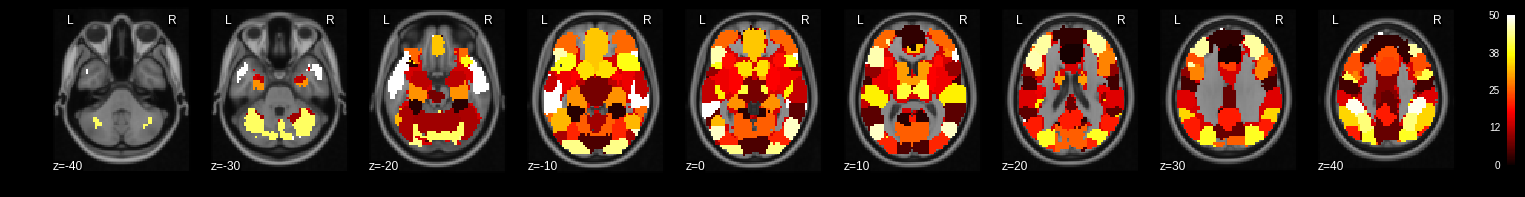

In [6]:
parcels.plot()

In [4]:
expanded_parcels = expand_mask(parcels)

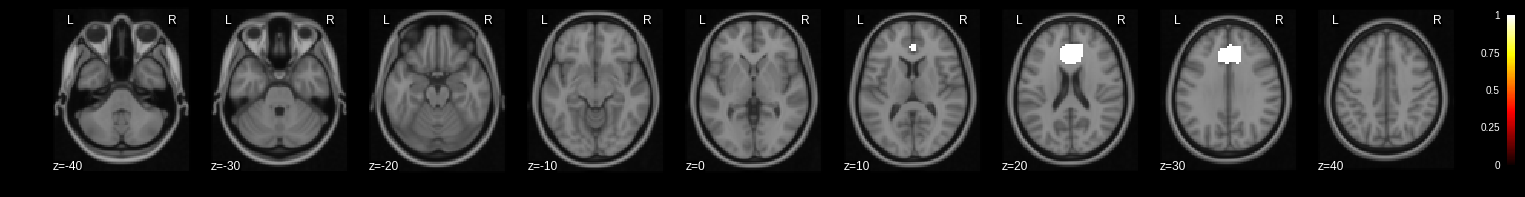

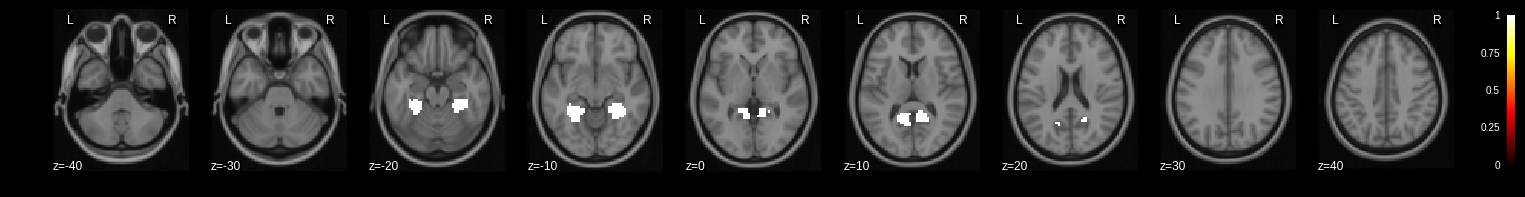

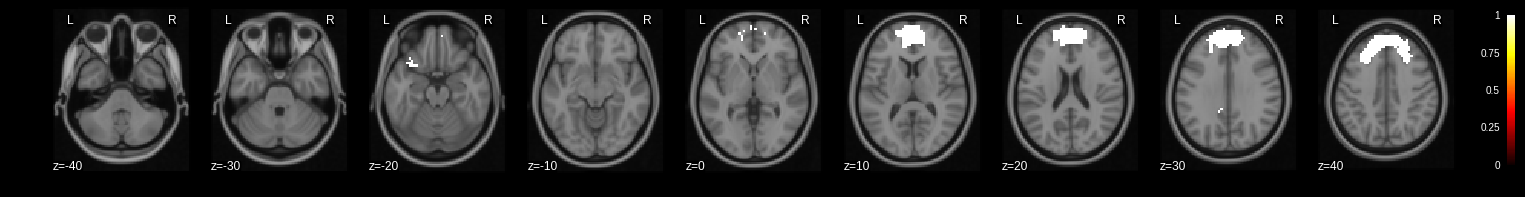

In [10]:
expanded_parcels.plot(3)

In [5]:
sub_list = glob(os.path.join(data_dir,'sherlock*'))
assert len(sub_list) == 16

In [6]:
sub = Brain_Data(sub_list[0],mask=mni_mask)

In [7]:
roi_1 = sub.apply_mask(expanded_parcels[0])

In [27]:
roi_1.data

array([[ 0.25184423,  0.23757298,  0.94339216, ..., -0.21877392,
        -0.04249965,  0.7549811 ],
       [ 2.0294385 ,  1.85683155,  1.78140295, ...,  0.1180405 ,
         0.41295958,  1.28797007],
       [ 0.23094706,  0.07849951,  0.24391533, ..., -1.04106748,
        -0.0668513 ,  0.9684571 ],
       ..., 
       [-0.77298945, -1.02399516, -1.29493988, ..., -0.57596409,
        -0.18160437, -0.06000435],
       [-2.08915496, -2.12524223, -1.83080316, ..., -2.75613236,
        -2.75575924, -1.77701724],
       [-0.73132056, -1.0503062 , -0.59713954, ..., -1.57879031,
        -1.32405317, -1.40630817]], dtype=float32)

In [14]:
np.save(os.path.join(data_dir,'test.npy'),roi_1.data,allow_pickle=False,fix_imports=False)

In [15]:
x = np.load(os.path.join(data_dir,'test.npy'))

In [17]:
x.shape

(1976, 528)

In [25]:
os.path.split(sub_list[0])

('/mnt/data', 'sherlock_movie_s11_resamp.nii.gz')

In [32]:
%%file extract_pattern_series.py
#!/usr/bin/env python

import argparse
from nltools.data import Brain_Data
from nltools.mask import expand_mask
import os
from glob import glob
import numpy as np

base_dir = '/mnt'
data_dir = os.path.join(base_dir,'data')
mask_dir = os.path.join(base_dir,'masks')
roi_dir = os.path.join(base_dir,'rois')
rois = glob(os.path.join(mask_dir,'k50*'))[0]
mni_mask = os.path.join(base_dir,'masks','MNI152_T1_3mm_brain_mask.nii.gz')

parser = argparse.ArgumentParser(description='Dumb script to resample subject data')
parser.add_argument('--input_file',required=True)
args = parser.parse_args()

sub_file = args.input_file
sub_num = os.path.split(sub_file)[-1].split('_')[2]

parcels = Brain_Data(rois,mask=mni_mask)
expanded_parcels = expand_mask(parcels)
dat = Brain_Data(sub_file, mask=mni_mask)

for i, roi in enumerate(expanded_parcels):
    
    roi_num = '_ROI_' + str(i) + '.npy'
    roi_dat = dat.apply_mask(roi)    
    np.save(os.path.join(roi_dir,sub_num + roi_num),roi_dat.data,allow_pickle=False,fix_imports=False)    

Overwriting extract_pattern_series.py


In [4]:
sub_list = glob(os.path.join(data_dir,'*.nii.gz'))

In [36]:
sub_list

['/mnt/data/sherlock_movie_s11_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s8_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s3_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s1_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s6_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s13_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s7_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s4_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s10_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s2_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s16_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s12_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s15_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s9_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s17_resamp.nii.gz',
 '/mnt/data/sherlock_movie_s14_resamp.nii.gz']

In [20]:
subs2

nltools.data.Brain_Data(data=(3952, 70256), Y=0, X=(0, 0), mask=MNI152_T1_3mm_brain_mask.nii.gz, output_file=[])

In [8]:
all_subs = Brain_Data(sub_list,mask=mni_mask)

In [29]:
sub_dat = [elem.T for elem in list(all_subs.data[:,:10,:])]

In [31]:
sub_dat[1].shape

(70256, 10)

In [38]:
from mpi4py import MPI
from brainiak.funcalign.srm import SRM

In [47]:
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

s3 = SRM(features=3)

In [48]:
s3.fit(sub_dat)

SRM(comm=<mpi4py.MPI.Intracomm object at 0x2adb6208c5e8>, features=3,
  n_iter=10, rand_seed=0)

In [49]:
s3.w_[0].shape

(70256, 3)

In [52]:
s3.s_.shape

(3, 10)

In [54]:
s3.mu_[0].shape

(70256,)